# Embed from Annotations Demo
Demonstrate how to use annotations in Concentriq® LS to define regions of interest to be embedded.

Steps:

- Create annotations on the Concentriq® LS platform.
- Fetch those annotations using the API
- Convert the annotations into bounding box regions representing tiles to be embedded
- Generate embeddings for those regions using the Concentriq® Embeddings API
- Visualize the resulting embedded tiles.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import yaml

from utils.concentriqlsclient import ConcentriqLSClient
from utils.client import ClientWrapper as ConcentriqEmbeddingsClient
from utils.annotations import viewport_to_pixel

### Instantiate the Embeddings and LS clients

In [2]:
with open('creds.yml', 'r') as file:
    creds = yaml.safe_load(file)

ce_api_client = ConcentriqEmbeddingsClient(**creds, device='cpu')
cls = ConcentriqLSClient(**creds)

In [3]:
image_id = 5370 # A sinlge image from the IMPRESS Dataset
embedder_model = 'bioptimus/H-optimus-0'
patch_size = 224  # Size of the patch is embedding model specific. H-optimus-0 uses 224.
embedding_mpp = 0.5 # Microns per pixel at which we will generate embeddings.
thumbnail_mpp = 7.0 # Microns per pixel at which thumbnails are generated by Concentriq Embeddings.

## Annotate regions of interest in Concentriq® LS

Annotations can be created in Concentriq® LS either manually, via bulk upload, or automatically via computational integration with the API (See `<your cls instance>/documentation/api-documentation/`).

Here we'll start with some manually created annotations:

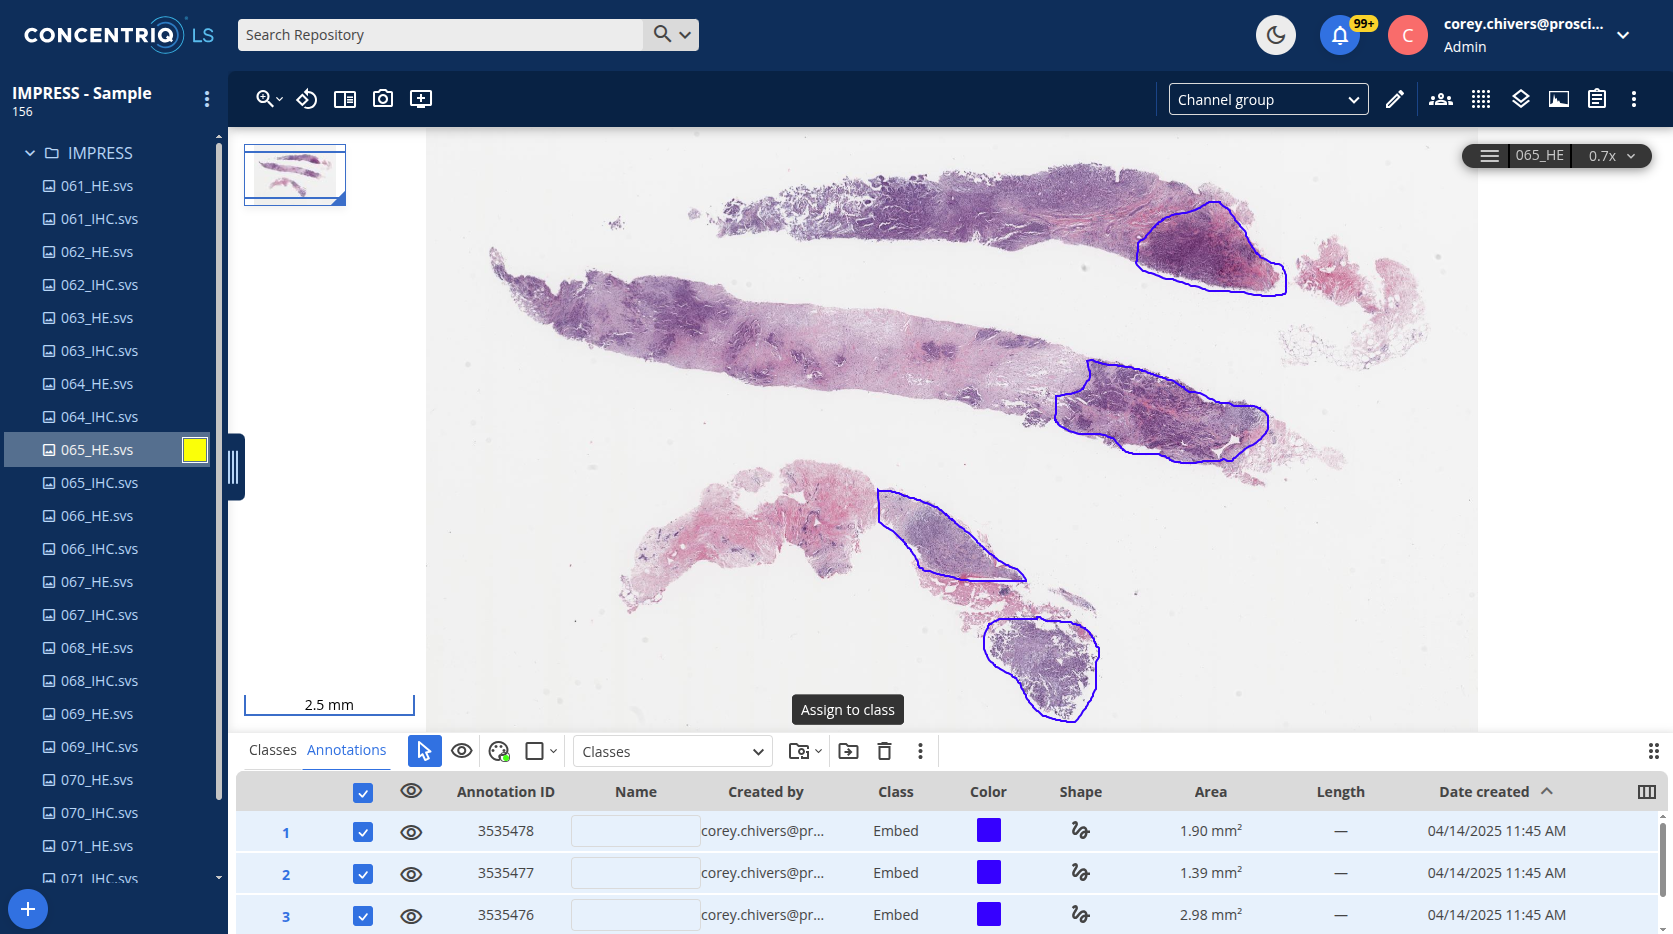

### Fetch the annotations

We'll fetch all the annotations associated with our target `image_id` and filter them to those with class name equal to 'Embed'. Creating annotation classes is a good way to track and group annotations for tasks like this, however you can use whatever filtering logic you prefer for this step.

In [4]:
annotations = cls.get_annotations(image_ids=[image_id])

# filter by annotation class name
annotations = [a for a in annotations['annotations'] if a['annotationClassName'] == 'Embed']
len(annotations)

4

### Fetch the thumbnail image

The Concentriq Embeddings provides an enpoint for generating 7mpp thumbnails to assist with visualization and RoI selection. We'll fetch the target image thumbnail next.

In [5]:
image_ids = [image_id]
ticket_id = ce_api_client.thumbnail_images(ids=image_ids)
thumbnails = ce_api_client.get_thumbnails(ticket_id, load_thumbnails=True)
thumbnail_img = thumbnails['thumbnails'][0]['thumbnail']

Waiting for job 0e827b2e-f9bf-4ed0-8436-987541eff185 to complete...
status='queued' progress=0.0 finished=0 failed=0 queued=1 processing=0
status='completed' progress=1.0 finished=1 failed=0 queued=0 processing=0


#### Fetch the base magnification (mpp) of the image

We'll fetch some metadata about the image and pull out the base magnification of the image which we'll need to compute our regions of interest.

In [6]:
image_data = cls.get_image_data(image_id=image_id)
base_mpp = image_data.get("mppx")

#### Convert annotations into bounding box regions

In order to specify the regions to embed, we'll convert the annotations into a series of bounding box regions which correspond to individual image patches (tiles). We'll put these into the frame of reference of the mpp and patch size of the embeddings we'll be generating.

Since we're embedding at 0.5 μm/px, and the patch size of our model (`H-optimus-0`) is 224, our regions will be 117 μm squares. We'll then scale these to 7 μm/px for compatibility with the `/embeddings/v1/roi-selection/` endpoint.

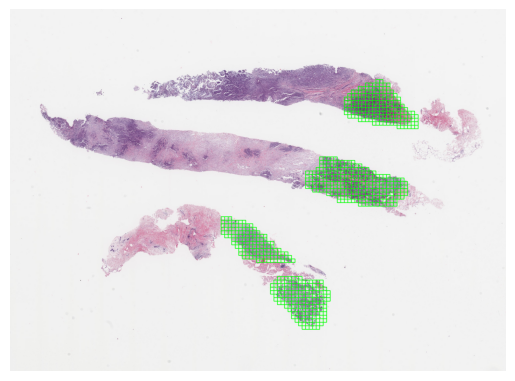

In [7]:
thumbnail = thumbnail_img.copy()
regions = []
embedding_patch_size = (patch_size * embedding_mpp)
thumbnail_patch_size = embedding_patch_size / thumbnail_mpp
scale_factor = (base_mpp / embedding_patch_size)
for annotation in annotations:
    shapestring = annotation.get("shapeString")
    # Convert the shape string to a numpy array
    annotation_poly = np.array(
        [[float(c) for c in coord.split(" ")] for coord in shapestring.split(",")[1:-1]]
    ) 
    # Close the polygon
    annotation_poly = np.concatenate((annotation_poly, annotation_poly[0:1]), axis=0) 
    annotation_poly = np.array([
        viewport_to_pixel(
            point,
            img_height=image_data["imgHeight"],
            img_width=image_data["imgWidth"]
        ) 
        for point in annotation_poly
    ])
    annotation_poly = (annotation_poly * scale_factor).astype(np.int32)
    
    max_x = np.max(annotation_poly[:, 0])
    max_y = np.max(annotation_poly[:, 1])
    mask = np.zeros((int(max_y+2), int(max_x+2)), dtype=np.uint8)
    # Draw filled polygon
    cv2.fillPoly(mask, [annotation_poly], 255)

    r = np.where(mask > 0)
    for x, y in zip(r[0], r[1]):
        regions.append({
            "x": int(x * thumbnail_patch_size),
            "y": int(y * thumbnail_patch_size),
            "width": int(thumbnail_patch_size),
            "height": int(thumbnail_patch_size),
        })

for r in regions:
    x = r['x']
    y = r['y']
    cv2.rectangle(
        thumbnail, 
        (r['x'], r['y']),
        (r['x'] + r['width'], r['y']+ r['height']),
        (0, 255, 0),
        2
    )
plt.imshow(thumbnail)
plt.axis('off')
plt.show()

# Submit a job containing regions of interest to be embedded

In [8]:
ticket_id = ce_api_client.embed_roi(
    image_id=image_id,
    regions=regions,
    mpp=embedding_mpp,
    model=embedder_model
)
print(ticket_id)

457bdc1a-ae85-4dd2-a1c7-0908697683b7


In [9]:
embeddings = ce_api_client.get_embeddings(ticket_id)

Waiting for job 457bdc1a-ae85-4dd2-a1c7-0908697683b7 to complete...
status='queued' progress=0.0 finished=0 failed=0 queued=1 processing=0


In [10]:
# Check that we used the correct patch size for the model
assert embeddings["images"][0]["patch_size"] == patch_size

# Visualize the resulting embedded patches
Here we'll use the Y_X grid locations of the embedings in conjunction with the embedding mpp that we requested to map the embedded patches onto the thumbnail and confirm that the locations are what we requested.

In [11]:
emb_keys = embeddings["images"][0]["embedding"].keys()
emb_locs = np.array([[int(coord) for coord in k.split("_")] for k in emb_keys])

(-0.5, 2255.5, 1645.5, -0.5)

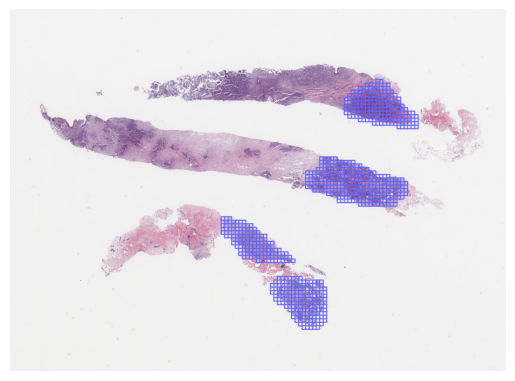

In [12]:
thumbnail = thumbnail_img.copy()
mpp = embeddings["images"][0]["mpp"]
patch_size = embeddings["images"][0]["patch_size"]
thumbnail_patch_size = round(patch_size * mpp / thumbnail_mpp)
mircons_per_patch = patch_size * mpp
w, h = thumbnail_patch_size, thumbnail_patch_size
for y, x in emb_locs:
    x_thumb = round(x * mircons_per_patch / thumbnail_mpp)
    y_thumb = round(y * mircons_per_patch / thumbnail_mpp)
    cv2.rectangle(thumbnail, (x_thumb, y_thumb), (x_thumb + w, y_thumb + h), (100, 100, 255), 4)
plt.imshow(thumbnail)
plt.axis("off")